## Types of single-nucleotide polymorphism 

In a population of chromosomes, a variety of alleles may be segregating at any given site. 
For example, the reference allele may be "C", 
but some chromosomes may harbor "A" as an ALT allele, and yet others may harbor "T" as a second ALT allele. 

There are eight possible categories to which a given site may belong (considering only single-nucleotide alleles):
one representing the case that a site is monomorphic (no ALT allele);
three representing the case where one ALT allele is segregating (there are three possible ALT alleles for each REF allele),
three representing the case where two ALT alleles are segregating (there are three possible ways to pair each of the three possible ALT alleles), 
one representing the case where all three possible ALT alleles are found in the population. 

A concrete description of these scenarios is presented in the following table, 
which corresponds to a REF allele of "C": 

$$ 
\begin{array}{ccccc}
A & G & T & \#ALTs & probs \\ 
\hline 
  &   &   & 0 & p_{C \rightarrow C} \\
* &   &   & 1 & p_{C \rightarrow A} \\
  & * &   & 1 & p_{C \rightarrow G} \\
  &   & * & 1 & p_{C \rightarrow T} \\
* & * &   & 2 & p_{C \rightarrow \{A,G\}} \\
* &   & * & 2 & p_{C \rightarrow \{A,T\}} \\
  & * & * & 2 & p_{C \rightarrow \{G,T\}} \\
* & * & * & 3 & p_{C \rightarrow \{A,G,T\}} \\
\end{array} 
$$

Though 2-ALT probabilities, e.g., $p_{C \rightarrow \{G,T\}}$, may depend upon single-ALT probabilities, e.g., $p_{C \rightarrow G}$ and $p_{C \rightarrow T}$, we make no attempt to model the dependence, in part because there are so many ways in which multiple ALT alleles could end up segregating at a site. (For example, if C, G and T alleles are segregating, then did the C allele mutate to the G allele, which then subsequently mutated to the T allele, or did the G and T alleles each arise by mutation of C?) Instead we simply estimate the probability of observing multiple ALT alleles segregating at a site. 

We estimate the probability $p_{C \rightarrow \{G,T\}}$, say, by
the fraction of sites that harbor the C allele in the reference genome, 
and segregate the C, G and T alleles in the cohort under consideration. 
Later we will use our estimates of all eight probabilites to predict the SNV count (number of ALT alleles) segregating in a genomic interval.



## Sequence-dependent polymorphism

It is now well-established that the probabilities mentioned above depend not only on the identity of the base in the reference genome at the polymorphic site, but also the bases in the reference genome that surround the polymorphic site [Halldorsson et al 2021; Li et al 2021; Feng, Deng, Li 2021; Iulio et al 2018, Aggarwala and Voight 2016; Samocha et al 2014]. To account for this,
we replace, for example, $p_{C \rightarrow \{A, T\}}$ by $p_{s \rightarrow \{A, T\}}$, where $s$ is a kmer whose center nucleotide is "C". 



## A model to predict the number of SNVs in a genomic interval



Let $N_i$ be a Categorical Random Variable representing the number of distinct ALT alleles at the site (genomic position) $i$, with local sequence context $s_i$.
If the center nucleodtide of $s_i$ is C, then the allowed values of $N_i$, and their corresponding probabilities are: 

$$ 
N_i = 
\left\{
\begin{array}{ll}
0 & p_i^{(0)} = p_{s_i \rightarrow C} \\
1 & p_i^{(1)} = p_{s_i \rightarrow A} + p_{s_i \rightarrow G} + p_{s_i \rightarrow T} \\
2 & p_i^{(2)} = p_{s_i \rightarrow \{A,G\}} + p_{s_i \rightarrow \{A,T\}} + p_{s_i \rightarrow \{G,T\}} \\ 
3 & p_i^{(3)} = p_{s_i \rightarrow \{A,G,T\}}
\end{array}
\right.
$$ 

In an interval containing $L$ sites, there are $L$ "trials" of an experiment with four possible outcomes (the possible values of $N_i$ at each site). Though the exact probability distribution of the number of occurrences of each outcome aggregated over $L$ trials is known ([Beaulieu 1991](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=76452&tag=1)), 
it is not immediately useful to us, as we are interested in a derived quantity, the number of SNVs in the interval:

\begin{equation*}
N = \sum_{i=1}^L N_i.
\end{equation*}

Though it is cumbersome to derive a formula for this distribution (starting from Beaulieu's result), and computationally inefficient to 
simulate the distribution on a genome-wide scale, 
we can make headway with the first two moments of the distribution 
since they are easy to compute. 

First consider the first two moments of $N_i$: 

$$ 
\begin{align*}
\langle N_i \rangle & = 1p_i^{(1)} + 2p_i^{(2)} + 3p_i^{(3)} \\
\langle N_i^2 \rangle & = 1^2p_i^{(1)} + 2^2p_i^{(2)} + 3^2p_i^{(3)} \\
\end{align*}
$$ 

From these we may compute the mean of $N$: 

$$ 
\begin{align*}
\langle N \rangle & = \sum_{i=1}^L \langle N_i \rangle 
\end{align*}
$$ 

and the variance of $N$,
assuming that the number of ALT alleles at nearby sites are not correlated with one another: 

$$ 
\begin{align*}
\text{var}(N) & = \sum_{i=1}^L \text{var}(N_i) & \text{(assumes independence)} \\
& = \sum_{i=1}^L \left( \langle N_i^2 \rangle - \langle N \rangle^2 \right)
\end{align*}
$$ 




## Detecting anomalous SNV counts

When the probabilities $p_{s_i \rightarrow a}$ are estimated using putatively neutral sites, the mean and variance 
computed above for a given genomic interval 
represent those expected under the assumption of neutrality, 
conditioned upon the sequence context of the interval 
(which would otherwise confound the analysis). 
Therefore when the test statistic 

$$ 
\overline{N} = \frac{N - \langle N \rangle}{\sqrt{\text{var}(N)}}
$$

is much greater than or much less than one, we reject the null model in favor of positive or negative selection, respectively. 



In [1]:
import numpy as np
from scipy.stats import bernoulli, poisson
from collections import Counter
from matplotlib import pyplot as plt 
%matplotlib inline 

number_sites = 50
exponents = 0.5*np.random.random_sample((number_sites,)) + 0.75
polymorphism_probabilities = 10**(-exponents) 

polymorphism_counts = []
number_examples = 10000
for example in range(number_examples):
  # given those polymorphism probabilities, one generates a set of polymorphisms: 
  is_polymorphism = [int(bernoulli.rvs(p, size=1)) for p in polymorphism_probabilities]
  polymorphism_counts.append(sum(is_polymorphism))

polymorphism_counts_histogram = Counter(polymorphism_counts)    
max_polymorphism_count = max(polymorphism_counts)
x = range(max_polymorphism_count+1)
probability_of_polymorphism_count = np.array([
    polymorphism_counts_histogram[value] 
    if value in polymorphism_counts_histogram 
    else 0 
    for value in x
])/number_examples

poisson_rate = sum(polymorphism_probabilities)

plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 16})    
plt.plot(x, probability_of_polymorphism_count, marker='s', label='Sum of Bernoulli variables')
plt.plot(x, poisson.pmf(x, poisson_rate), 'r-o', ms=8, label='Poisson variable')
plt.xlabel(f'number of polymorphic sites, $n$, in an interval of length {number_sites}')
plt.ylabel('probability, $P[N=n]$')
plt.legend(loc='upper left', bbox_to_anchor=(1.04,1), fontsize=16) 
plt.title(f'site polymorphism probabilities range from {np.min(polymorphism_probabilities):.4f} to {np.max(polymorphism_probabilities):.2f}')

KeyboardInterrupt: 

## A hypothesis test based upon allele frequencies 

Consider the following data taken from version 3 of the gnomad browser concering a polymorphic site: 

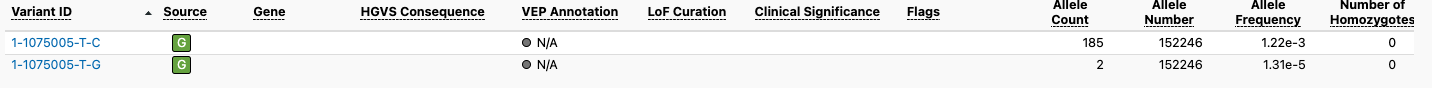

In [49]:
# embed raw image data in notebook: 
# https://github.com/microsoft/vscode-jupyter/issues/6437
from IPython.display import Image
Image(filename='gnomad-allele-frequencies.png', width=2000)

These data tell us that, at site chr1:1,075,005, there are three segregating alleles: T, C and G. If we imagine "breaking apart" all the genotypes that were confidently called at this site, 
and pooling the resulting 152,246 chromosomes, then 185 of those chromosomes harbor the C allele, and 2 of them harbor the G allele. The remaining chromosomes harbor the T allele. (Note that we cannot know, based upon these data alone, how many of each of the possible diploid genotypes (T/T, T/C, T/G, G/C) exist in the cohort.)

We expect that leveraging both the number of polymorphic sites AND the ALT allele frequencies observed at those sites will increase our ability to reliably discover natural selection. For example, when the number of SNPs in a 100bp interval, say, is smaller than the number expected given the sequence that appears in those 100bp, one *might* suspect that purifing selection has been acting. Further, if the frequencies of the ALT alleles at those sites are smaller, in some sense, than an expectation derived from putatively neutral regions, then one's confidence in rejecting the neutral hypothesis is increased. 



## TODO: 
We can build a hypothesis test along these lines. Collect a large sample of 100bp regions, say. Stratify by the number of polymorphic sites per window, e.g., a stratum may consist of all windows with 10 or fewer SNPs. For each stratum, compute the fraction of SNPs in each window that are singletons in the population sample (cohort) under consideration. These empirical distributions (one for each stratum) yield approximations to a set of p-values: $P[F > f \, | \, N \leq n]$. The conditioning is important as population-genetics simulations lead us to expect $P[F = f \, | \, N = n]$ to be wider when $N$ is smaller ([see here](https://docs.google.com/presentation/d/11jOQA2BSNMa10xb5lSksZDqiiyCr8Kgl6cDOCAFSFGA/edit?usp=sharing)). Reject the null hypothesis of neutrality when the computed p-value lies below a multiple-hypothesis-corrected significance threshold. 



# A combined statistical hypothesis test to call constraint (purifying selection)

We now know how to compute two p-values. The first, $P[N \leq n]$, represents the chance, under neutrality, that a SNP count is as low as observed given the sequence context. The second, $P[F>f \, | \, N \leq n]$, represents the chance that the fraction of those SNPs that are singletons, $F$, is as high as the observed value, $f$, given the event that that there are $n$ or fewer SNPs in the window. 

Formulating the problem as two (dependent) p-values allows us to gauge the impact of the use of allele frequencies upon constraint discovery. Concretely, we can compare recall-FDR curves obtained using the p-value $P[N \leq n]$ with those obtained using the *joint* p-value $P[F>f \, , \, N \leq n] = P[F>f \, | \, N \leq n] \, P[N \leq n]$. 





